In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from molten.data_drift.hdddm import HDDDM
import seaborn as sns


wls = pd.read_csv('/Users/ilindsay/The MITRE Corporation/iMOLTEN - General/Synthetic Data/fake_wls_eligibility.csv', index_col = 'tin')
drift = wls[wls.drift == True]
drift.tax_yr.value_counts()



2014    20000
2016    20000
2018    20000
Name: tax_yr, dtype: int64

In [3]:
#setting up dataset
ref_2012 = wls[wls.tax_yr == 2012].iloc[:,1:11]
ref_1 = ref_2012.iloc[0:int(len(ref_2012)/2),]
ref_2 = ref_2012.iloc[int(len(ref_2012)/2):,]
test_batches = {}
for year in wls.tax_yr.value_counts().index[1:]:
    data = wls[wls.tax_yr == year]
    test_batches[year] = data.iloc[:,1:11]

#initializing HDDDM
hd3m = HDDDM(ref_1, subsets = 5)
hd3m.update(ref_2)

#detecting drift 
drift_features = []
feature_eps = []
for year in test_batches:
    hd3m.update(test_batches[year])
    feature_eps.append(hd3m.feature_epsilons)
    if hd3m.drift_state == 'drift':
        print("drift in ", year)
        drift_features.append(hd3m.feature_info['hellinger distances'])
       
diff = hd3m.epsilon_values
dist = hd3m.distances
thresh = hd3m.thresholds

drift in  2014
drift in  2017
drift in  2019


In [3]:
#storing statistics in usable format
thresholds = list(thresh.values())
epsilons = list(diff.values())
distances = list(dist.values())[1:] #ignoring first distnace, from 2012.5
differences = []
betas = []
for i in range(2,9):
    if i in diff.keys():
        differences.append(diff[i])
        betas.append(thresh[i])
    else:
        differences.append(0)
        betas.append(0)

In [4]:
sns.set_style("white")

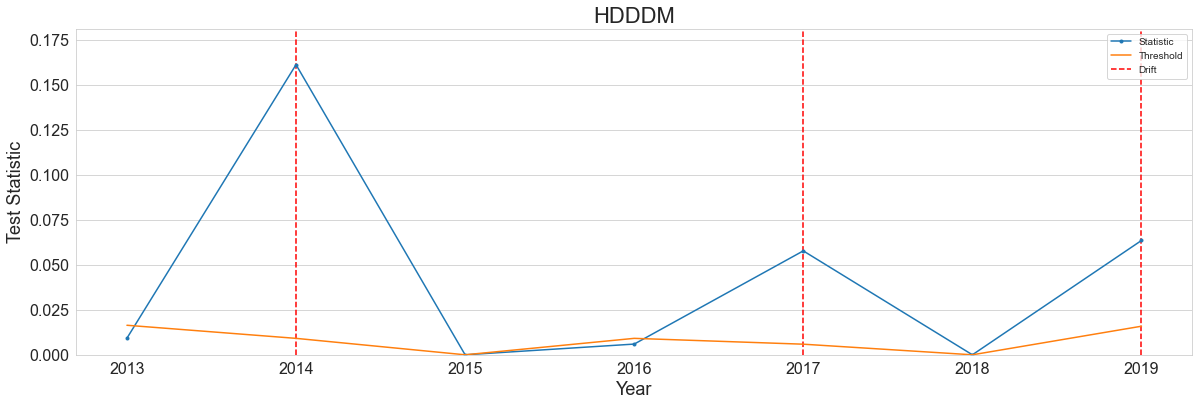

In [39]:
all_years = ["2013","2014","2015","2016","2017","2018","2019"]
drifts = [False, True, False, False, True, False, True]
#stat= ['differences'] * 7 + ['thresholds'] * 7 
#values = differences + betas 
#thresh_data = {'year':all_years*2, 'stat':stat, 'value': values, 'drift': drifts*2}
thresh_data = {'year':all_years, 'epsilon':differences,'threshold':betas, 'drift': drifts}
thresh_data = pd.DataFrame(thresh_data)
#plt.plot(data = thresh_data, x = "year", y = "value", hue = 'stat')
#plt.axvline(x=2014, color='r', linestyle='-')

plt.figure(figsize=(20, 6))
plt.plot('year','epsilon', data=thresh_data, label = 'epsilon',  marker = ".")
plt.plot('year','threshold', data=thresh_data, label = 'threshold')
plt.grid(False, axis='x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('HDDDM', fontsize=22)
plt.ylabel('Test Statistic', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylim([0,max(differences)+0.02])


#plt.vlines(x=status1.loc[retrain_end, 'index'], ymin=0, ymax=1.1, colors='green', linewidth = 7)

for t in thresh_data.loc[thresh_data['drift'] == True]['year']:
    plt.vlines(x=t, ymin=0, ymax=max(differences)+0.02,colors='red', linestyle = 'dashed') # 
    
plt.legend(['Statistic','Threshold','Drift'])   
plt.savefig('WLS_test_statistics.png')
plt.show()


In [60]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.transform import dodge

all_years = ["2013","2014","2015","2016","2017","2018","2019"]
drift = [0,max(differences)+0.001,0,0,max(differences)+0.001,0,max(differences)+0.001]
drifts = [False, True, False, False, True, False, True]
stat= ['differences'] * 7 + ['thresholds'] * 7 
values = differences + betas 
#thresh_data = {'year':all_years*2, 'stat':stat, 'value': values, 'drift': drifts*2}
thresh_data = {'year':all_years, 'epsilon':differences,'threshold':betas, 'drift': drifts}
thresh_data = pd.DataFrame(thresh_data)

p = figure(title = 'HDDDM: WLS Drift Statistics', x_axis_label = 'Year', y_axis_label = 'Test Statistic')

p.line(all_years, differences, legend_label = 'Differences', line_width = 2, color = '#92a8d1' )

p.line(all_years, betas, legend_label = 'Threshold', line_width = 2, color = '#ffcc5c') #red = '#ff6f69'

source_drift = ColumnDataSource(data = dict(year = all_years, drift = drift))

#p.vbar(x=dodge('year',0,range = p.x_range), top='drift', width=0.05, source=source_drift, color='#ff6f69', legend_label="Drift")

p.legend.location = "top_left"
p.legend.orientation = "vertical"
show(p)

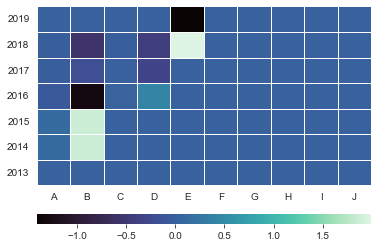

In [18]:
sns.set_style("whitegrid")

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(feature_eps, ax=ax, cmap=sns.color_palette("mako", as_cmap=True),  yticklabels = ["2013","2014","2015","2016","2017","2018","2019"], xticklabels = ["A","B","C","D","E","F","G","H","I","J"], linewidths = 0.5,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"})

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.show()

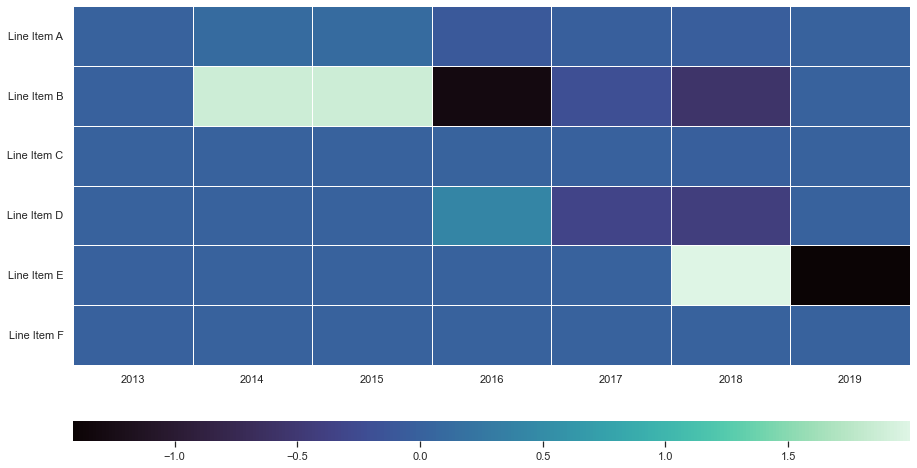

In [41]:
sns.set(rc = {'figure.figsize':(15,8)})
inverted_matrix = []
for alpha in range(0,6): #for a, b, c, d, e, f (not g, h, i ,j)       
    line_items = []
    for year in range(len(feature_eps)):
        line_items.append(feature_eps[year][alpha])
    inverted_matrix.append(line_items)

sns.set_style("whitegrid")

grid_kws = {"height_ratios": (.9, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
ax = sns.heatmap(inverted_matrix, ax=ax, cmap=sns.color_palette("mako", as_cmap=True),  xticklabels = ["2013","2014","2015","2016","2017","2018","2019"], yticklabels = ["Line Item A","Line Item B","Line Item C","Line Item D","Line Item E","Line Item F"], linewidths = 0.5,
                 cbar_ax=cbar_ax,
                 cbar_kws={"orientation": "horizontal"}) #

ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.savefig('WLS_feature_heatmap.png')
plt.show()



In [24]:
len(inverted_matrix[0])

7